# CLV Data Mining

In [1]:
# import the required packages
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from datetime import datetime

So far the **migration modeling**. Time to get back to our **data mining** methodology. 

We now know what we should do: model CLV during 2004-2006.

We are going to create a **predictive model** with the same independent variables as in the **churn case**.

The difference this time is our **dependent variable**: ``CLV``. 
We will give you the code to create the independent features, since you already learned how to model them during the churn case.

**Two models** will be created:  
- A classification churn model  
- A regression clv model

Because if we would simply regress CLV, our model would be **biased** towards those zeros, leading to a consistent underestimation.

We are going to **predict CLV if customers did not churn**.

(See theory)

# 1. Data Exploration

In [2]:
# import all the datasets
extrel = pd.read_csv("./data/extrel.csv")
extrelty = pd.read_csv("./data/extrelty.csv")
communication = pd.read_csv("./data/communication.csv")
payhistory = pd.read_csv("./data/payhistory.csv")
nameaddr = pd.read_csv("./data/nameaddr.csv")
comclas = pd.read_csv("./data/comclas.csv")
commediu = pd.read_csv("./data/commediu.csv")

In [3]:
# inspect first observation extrel
extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,26414,CT,2008-01-30,NaT
1,26419,FP,2005-02-26,NaT
2,26424,FP,2005-02-26,2009-12-21
3,26430,FP,2005-02-26,2019-01-28
4,26430,CT,2010-03-04,NaT


In [4]:
# inspect dtypes of columns
extrel.dtypes

EXTRELNO       int64
EXRELACTCD    object
EXTRELSTDT    object
EXRELDATEN    object
dtype: object

In [5]:
# inspect shape
extrel.shape

(26689, 4)

In [6]:
# inspect payhistory
payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [7]:
# inspect shape
payhistory.shape

(1205720, 6)

## 2. Time Window

In [8]:
# define the model building time window
end_independent = datetime.strptime("22/11/2016", "%d/%m/%Y")
start_dependent = datetime.strptime("01/01/2017", "%d/%m/%Y")
end_dependent = datetime.strptime("31/12/2019", "%d/%m/%Y")

# 3. Data Preparation

## 3.1. Customers

We need to take a relevant subset of modelable customers just as we did in the churn case. Therefore we have to make **some constraints** in this CLV-case:

1. The donors have to be **active during the independent period**: they needed to start their relationship with the company before the end of the independent period.
2. We are **not interested** in donors that ended their relation before the start of the dependent.
3. Extra condition in comparison to churn case : take only the donors that **made already a transaction by the end of the independent period**.

In [9]:
# convert start date EXTRELSTDT and end date EXRELDATEN to datetimes
extrel["EXTRELSTDT"] = pd.to_datetime(extrel["EXTRELSTDT"], format='%Y-%m-%d')
extrel["EXRELDATEN"] = pd.to_datetime(extrel["EXRELDATEN"], format='%Y-%m-%d')

In [10]:
# extract the active donors
active_customers = extrel[(extrel["EXTRELSTDT"] <= end_independent) & 
                        ((extrel["EXRELDATEN"] > start_dependent) | (extrel["EXRELDATEN"].isnull()))]

In [11]:
# get unique customers
active_customers = active_customers["EXTRELNO"].unique()
# convert to DataFrame 
active_customers = pd.DataFrame(active_customers)
# rename column
active_customers.columns = ["EXTRELNO"]
# sort by EXTRELNO 
active_customers = active_customers.sort_values(by=["EXTRELNO"])

In [12]:
# convert payhistory PDATE to datetime
payhistory["PDATE"] = pd.to_datetime(payhistory["PDATE"], format='%Y-%m-%d')

In [13]:
# extract only those transactions which were made before the end of the independent period
payhistory_ind = payhistory[payhistory["PDATE"] <= end_independent]
# extract only observations with positive transactions
payhistory_ind = payhistory_ind[payhistory_ind["PAMT"] > 0]

In [14]:
# sort data by extrelno and pdate
payhistory_ind = payhistory_ind.sort_values(by=["EXTRELNO", "PDATE"])

In [15]:
# get unique set of customers with transactions during the independent period
transaction_customers = payhistory_ind["EXTRELNO"].unique()
# convert to DataFrame
transaction_customers = pd.DataFrame(transaction_customers)
# rename column
transaction_customers.columns = ["EXTRELNO"]

In [16]:
# merge both tables to get active customers that made transaction during independent period
customers = pd.merge(active_customers, transaction_customers, on="EXTRELNO", how="inner")

In [17]:
# check
customers.head()

,EXTRELNO
0,26414
1,26419
2,26430
3,26431
4,26443


## 3.2. Independent Variables

### 3.2.1. Independent information

For creating the **independent variables** such as *recency*, *frequency*, *monetary value*, etc. we first need to make sure that we will only use information during the **independent period**.

In [18]:
# the payhistory from independent period was already calculated in previous step
payhistory_ind.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38,2006-12-28,9.57,19,X,CO
1,39,2006-12-28,41.32,20,X,CO
2,40,2006-12-28,13.10,20,X,CO
3,54091,2006-12-29,2.02,20,X,CO
4,104480,2007-05-16,0.50,20,D,OK


In [19]:
# convert communication CONTDATE to datetime
communication["CONTDATE"] = pd.to_datetime(communication["CONTDATE"], format='%Y-%m-%d')

In [20]:
# extract only those transactions which were made before the end of the independent period
communication_ind = communication[communication["CONTDATE"] <= end_independent]

In [21]:
# sort transactions by EXTRELNO and CONTDATE
communication_ind = communication_ind.sort_values(by=["EXTRELNO", "CONTDATE"])

In [22]:
# check
communication_ind.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,405402,CI,CTS,CT,20,O,2007-05-06
1,430904,CI,CTS,CT,20,O,2007-06-11
2,592732,CI,CTS,CT,20,O,2007-10-18
3,593375,CI,CTS,CT,20,O,2007-10-18
4,618514,CI,CTS,CT,20,O,2007-11-25


### 3.2.2. Frequency

**Frequency**: the number of transactions made by a customer during the independent period

In [23]:
# get the frequency: number of transactions per customer
frequency = payhistory_ind["EXTRELNO"].value_counts().reset_index()
# rename columns
frequency.columns = ["EXTRELNO", "frequency"]

In [24]:
# check
frequency.head()

,EXTRELNO,frequency
0,1773,2131
1,35231,1121
2,34337,642
3,202611,610
4,2980,583


### 3.2.3. Recency

**Recency**: the number of days between a customer's last transaction and the end of the independent period

In [25]:
# get the last transactions of each donor
recency = payhistory_ind.groupby("EXTRELNO").tail(1)[["EXTRELNO", "PDATE"]]
# get the recency in days 
recency["recency"] = recency["PDATE"].apply(lambda x: (end_independent - x).days)
# drop PDATE
recency = recency.drop("PDATE", axis=1)

In [26]:
# check
recency.head()

,EXTRELNO,recency
0,19,3617
120,20,13
275,35,13
397,42,1048
627,43,135


### 3.2.4. Monetary Value

**Monetary value**: the average and total amount of transactions made by a customer during the independent period

In [27]:
# get the total and average monetary value per customer
monetary_value = payhistory_ind.groupby("EXTRELNO").agg({"PAMT": [np.sum, np.mean]}).reset_index()
# rename columns
monetary_value.columns = ["EXTRELNO", "total_value", "average_value"]

In [28]:
# check
monetary_value.head()

,EXTRELNO,total_value,average_value
0,19,9.57,9.570000
1,20,2321.30,19.506723
2,35,2292.40,19.593162
3,42,1563.36,18.611429
4,43,4413.90,19.444493


### 3.2.5. Paytypes

**Paytype**: indication of whether a customer has ever used a particular paytype during the independent period 

         D: order
         E: initiative
         O: sendout
         X: unknown

In [29]:
# get a unique set of paytypes used per donor
paytypes = pd.DataFrame(payhistory_ind.groupby("EXTRELNO").agg({"PAYTYPECD": set}).reset_index())

In [30]:
# create indicators for paytypes used per donor
paytypes["sendout"] = paytypes["PAYTYPECD"].apply(lambda x: 1 if "O" in x else 0)
paytypes["order"] = paytypes["PAYTYPECD"].apply(lambda x: 1 if "D" in x else 0)
paytypes["initiative"] = paytypes["PAYTYPECD"].apply(lambda x: 1 if "E" in x else 0)
paytypes["unknown"] = paytypes["PAYTYPECD"].apply(lambda x: 1 if len(x.difference(set(["O", "D", "E"]))) > 0 else 0)

In [31]:
# drop the paytype column
paytypes = paytypes.drop("PAYTYPECD", axis=1)

In [32]:
# check
paytypes.head()

,EXTRELNO,sendout,order,initiative,unknown
0,19,0,0,0,1
1,20,0,1,0,1
2,35,0,1,0,1
3,42,0,1,0,1
4,43,0,1,0,1


### 3.2.6. Preferred Language

**Preferred mailing language**: get the preferred mailing language of a donor

In [33]:
# get preferred mailing language of donor
language = pd.get_dummies(nameaddr, columns=['LANGUACODE'], drop_first = True)
language = language[['EXTRELNO', 'LANGUACODE_FR', 'LANGUACODE_NL']]
language.head()

,EXTRELNO,LANGUACODE_FR,LANGUACODE_NL
0,19,0,1
1,20,0,1
2,35,0,1
3,42,0,1
4,43,0,1


### 3.2.7. Complaints

Complaint and direction: check if a donor has ever complaint or has given some kind of direction

        CM: Complaint
        I: Direction

In [34]:
# get a unique set om communication types per donor
complaint = communication_ind.groupby("EXTRELNO").agg({"CLASCODE": set, "CONTDIREC": set}).reset_index()
# create indicators for complaint and direction
complaint["complaint"] = complaint["CLASCODE"].apply(lambda x: 1 if "CM" in x else 0)
complaint["direction"] = complaint["CONTDIREC"].apply(lambda x: 1 if "I" in x else 0)
# keep relevant variables
complaint = complaint[["EXTRELNO", "complaint", "direction"]]

In [35]:
# check
complaint.head()

,EXTRELNO,complaint,direction
0,20,0,0
1,35,0,1
2,42,0,1
3,43,0,1
4,60,0,1


We will already store all the independent variables in **one dataset**, which we can than **merge** with the dependent variables.

In [36]:
# create dataset with all independent features
indep_basetable = (pd.merge(pd.DataFrame(customers["EXTRELNO"]), frequency, how="left", on="EXTRELNO")
                    .merge(recency, how="left", on="EXTRELNO")
                    .merge(monetary_value, how="left", on="EXTRELNO")
                    .merge(paytypes, how="left", on="EXTRELNO")
                    .merge(complaint, how="left", on="EXTRELNO")
                    .merge(language, how="left", on="EXTRELNO"))

In [37]:
# check
indep_basetable.head()

,EXTRELNO,frequency,recency,total_value,average_value,sendout,order,initiative,unknown,complaint,direction,LANGUACODE_FR,LANGUACODE_NL
0,26414,117,13,2257.13,19.291709,0,1,0,1,0.0,1.0,0,1
1,26419,47,56,2556.99,54.404043,1,0,0,1,0.0,1.0,0,1
2,26430,119,13,2299.28,19.321681,1,1,0,1,1.0,1.0,0,1
3,26431,14,203,2742.57,195.897857,1,0,0,1,0.0,0.0,0,1
4,26443,116,13,2276.95,19.628879,0,1,0,1,0.0,0.0,0,1


In [38]:
# check dimensions
indep_basetable.shape

(7039, 13)

## 3.3. Dependent Variables

Since we have a **two-phase model** here, we need **two dependent variables**:

- ``CLV`` is in this case defined as the sum of all discounted purchases in the dependent period (3 year)
- ``CHURN`` is in this case defined as a customer who didn't donate anything in the dependent period (CLV=0)

### 3.3.1. CLV

In [39]:
# define the discount rate
DISCOUNT_RATE = 0.05

In [40]:
# get payhistory information from dependent period
payhistory_dep = payhistory[(payhistory["PDATE"] >= start_dependent) & (payhistory["PDATE"] <= end_dependent)]

In [41]:
# define function to get discounted transaction
def get_discounted_transaction(trans_date, trans_val):
    
    # get discounted transaction
    disc_trans = trans_val / ((1 + DISCOUNT_RATE) ** ((trans_date - start_dependent).days / 365.))
    
    # return
    return(disc_trans)

In [42]:
# discount each transaction by a daily discount rate
payhistory_dep["PAMT_discounted"] = payhistory_dep.apply(lambda x: get_discounted_transaction(x["PDATE"], x["PAMT"]), axis=1)

C:\Users\dvmulder\AppData\Local\Temp\ipykernel_21116\2755635735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payhistory_dep["PAMT_discounted"] = payhistory_dep.apply(lambda x: get_discounted_transaction(x["PDATE"], x["PAMT"]), axis=1)


In [43]:
# get total of discounted transaction per customer
clv = payhistory_dep.groupby("EXTRELNO").agg({"PAMT_discounted": sum}).reset_index()
# rename columns
clv.columns = ["EXTRELNO", "CLV"]

In [44]:
# check
clv.head()

,EXTRELNO,CLV
0,20,770.965937
1,35,770.965937
2,72,770.862336
3,81,2303.809274
4,89,748.721848


### 3.3.2. Churn

In [45]:
# merge clv dataset with customer data
churn_clv = pd.merge(customers, clv, on="EXTRELNO", how="left")
# only keep EXTRELNO and CLV
churn_clv = churn_clv[["EXTRELNO", "CLV"]]

In [46]:
# set clv to 0 for customers that did not make any transaction during dependent period
churn_clv["CLV"] = churn_clv["CLV"].fillna(0)
# set churn to 1 for customers that did not make any transaction during dependent period
churn_clv["churn"] = np.where(churn_clv["CLV"] > 0,0,1)

In [47]:
# check
churn_clv.head()

,EXTRELNO,CLV,churn
0,26414,770.965937,0
1,26419,771.030576,0
2,26430,484.389230,0
3,26431,777.367765,0
4,26443,770.965937,0


In [48]:
# check churn proportions
churn_clv["churn"].value_counts(normalize=True) * 100

0    91.575508
1     8.424492
Name: churn, dtype: float64

In [49]:
# check mean and stddev of positive CLV
print("mean CLV: %s" %churn_clv["CLV"][churn_clv["CLV"] > 0].mean())
print("stddev CLV: %s" %churn_clv["CLV"][churn_clv["CLV"] > 0].std())

mean CLV: 754.5486067420968
stddev CLV: 307.0191700907327


In [50]:
# check mean and stddev of all
print("mean CLV: %s" %churn_clv["CLV"].mean())
print("stddev CLV: %s" %churn_clv["CLV"].std())

mean CLV: 690.6549348376444
stddev CLV: 361.661059381804


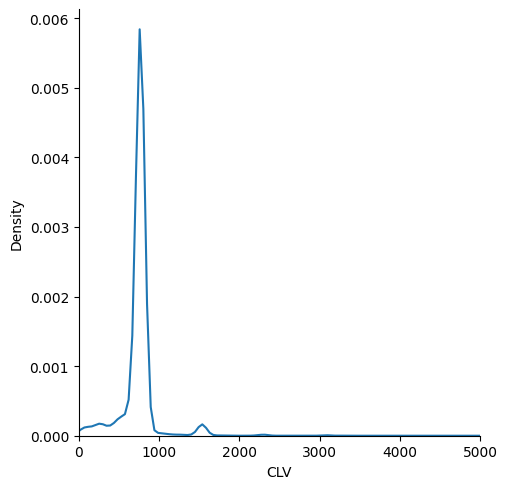

In [51]:
# plot distribution
sns.displot(churn_clv["CLV"][churn_clv["CLV"] > 0], kind="kde")
plt.xlim(0, 5000)
plt.show()

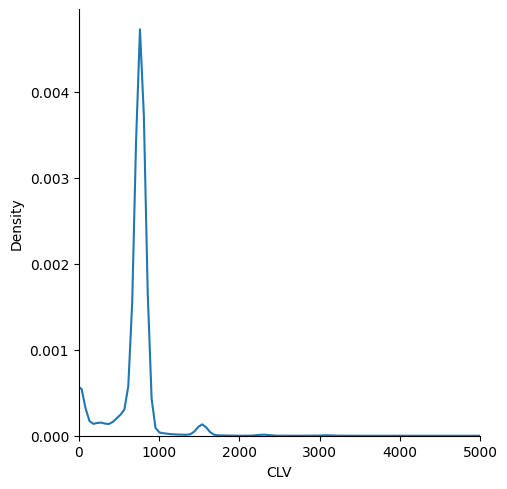

In [52]:
# plot distribution with churners added
sns.displot(churn_clv["CLV"], kind="kde")
plt.xlim(0, 5000)
plt.show()

In [53]:
# check dimensions
churn_clv.shape

(7039, 3)

**Remember why we modelled churn in a two-phase model?** 

Because otherwise our sample would be **induced by zero values** for our regression model. However, our sample is induced much stronger by another value: the **default donation contracts**! (i.e., CLV around 770). So should we not tackle this? In fact it might be better to model this seperately, rather than churn: *default_value if P(default), E(CLV) otherwise*. Or even in a **three-phase model**!

But in this case, we will be using the more default way to model CLV, with **churn probability** as secondary input, as this is the most common way. Be aware, however, that you might need to model it slightly different in reality. Always inspect your data!

## 3.4. Basetable

Create the **final basetable** by joining all the independent variables with the dependent variables

In [54]:
# merge
basetable = (pd.merge(indep_basetable, churn_clv, how="left", on="EXTRELNO"))

In [55]:
# check
basetable.head()

,EXTRELNO,frequency,recency,total_value,average_value,sendout,order,initiative,unknown,complaint,direction,LANGUACODE_FR,LANGUACODE_NL,CLV,churn
0,26414,117,13,2257.13,19.291709,0,1,0,1,0.0,1.0,0,1,770.965937,0
1,26419,47,56,2556.99,54.404043,1,0,0,1,0.0,1.0,0,1,771.030576,0
2,26430,119,13,2299.28,19.321681,1,1,0,1,1.0,1.0,0,1,484.389230,0
3,26431,14,203,2742.57,195.897857,1,0,0,1,0.0,0.0,0,1,777.367765,0
4,26443,116,13,2276.95,19.628879,0,1,0,1,0.0,0.0,0,1,770.965937,0


In [56]:
# check dimensions of basetable
basetable.shape

(7039, 15)

# 4. Modeling

## 4.1. Split basetable into training and test

First, we are going to **randomly split** our basetable into a training and test set.
        
        training set: this data will be used to train our model
        validation set: check which churn treshold works best
        test set: this data will be used to get an unbiased evaluation of our model
        
For this specific case, we will put 70% of the data into the **training set** and 30% of the data into the **test set**.

In [57]:
# split data into train and test by making use of sklearn train_test_split function
# set seed (random_state) equal to 33 to reproduce the same results
basetable_train, basetable_test = train_test_split(basetable, test_size=0.3, random_state=33, stratify = basetable['churn'])

In [58]:
# check dimensions
print(basetable_test.shape)
print(basetable_train.shape)

(2112, 15)
(4927, 15)


Now split up into ``X`` and ``Y`` for the **fitting** of your models.

**Remember**: We now have **two models**, so each model needs its own independent variables and dependent variable.
    
For the **churn model** we use ``all`` independent variables.  
For the **clv model** we use ``recency``, ``frequency`` and ``monetary value`` (average + total)

In [59]:
# get features and dependent variable for predicting churn 
train_X_churn = basetable_train.drop(["EXTRELNO", "churn", "CLV"], axis=1)
train_y_churn = basetable_train["churn"]

test_X_churn = basetable_test.drop(["EXTRELNO", "churn", "CLV"], axis=1)
test_y_churn = basetable_test["churn"]

In [60]:
# get features and dependent variable for predicting CLV
train_X_clv = basetable_train[["recency", "frequency", "total_value", "average_value"]]
train_y_clv = basetable_train["CLV"]

test_X_clv = basetable_test[["recency", "frequency", "total_value", "average_value"]]
test_y_clv = basetable_test["CLV"]

## 4.2. Pre-Processing

We will handle the **missing values** and **scaling** the same way we handled them during the churn case: replace missing values (besides recency) with ``0`` and create ``indicator`` that you imputed them.

In [61]:
# check missing values in independent features of test set (clv model)
test_X_clv.isnull().sum()/len(test_X_clv)

recency          0.0
frequency        0.0
total_value      0.0
average_value    0.0
dtype: float64

In [62]:
# check missing values in independent features of train set (clv model)
train_X_clv.isnull().sum()/len(train_X_clv)

recency          0.0
frequency        0.0
total_value      0.0
average_value    0.0
dtype: float64

In [63]:
# check missing values in independent features of test set (churn model)
test_X_churn.isnull().sum()/len(test_X_churn)

frequency        0.000000
recency          0.000000
total_value      0.000000
average_value    0.000000
sendout          0.000000
order            0.000000
initiative       0.000000
unknown          0.000000
complaint        0.001894
direction        0.001894
LANGUACODE_FR    0.000000
LANGUACODE_NL    0.000000
dtype: float64

In [64]:
# check missing values in independent features of train set (churn model)
train_X_churn.isnull().sum()/len(train_X_churn)

frequency        0.000000
recency          0.000000
total_value      0.000000
average_value    0.000000
sendout          0.000000
order            0.000000
initiative       0.000000
unknown          0.000000
complaint        0.000203
direction        0.000203
LANGUACODE_FR    0.000000
LANGUACODE_NL    0.000000
dtype: float64

As you can see there is **no imputation required** for CLV model! How is this possible? We used another **sampling definition**.

In [65]:
# only handle churn imputation
train_X_churn['had_missing'] = train_X_churn.isnull().any(axis=1).astype(int)
test_X_churn['had_missing'] = test_X_churn.isnull().any(axis=1).astype(int)

# treatment other variables: no information used from training set ==> same code for train / test set (zero remains zero)
train_X_churn[['complaint', 'direction']] = train_X_churn[['complaint', 'direction']].fillna(value=0)
test_X_churn[['complaint', 'direction']] = test_X_churn[['complaint', 'direction']].fillna(value=0)

Let's now perform the **scaling** on both sets (only features with range outside [0,1], like we did in the churn case):

In [66]:
# scale both sets: only features with range outside [0,1] (cf. churn case)

# scale numeric features from churn dataset
scaler = MinMaxScaler()

scaler.fit(train_X_churn[['total_value', 'average_value', 'recency', 'frequency']])

train_X_churn[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(train_X_churn[['total_value', 'average_value', 'recency', 'frequency']])
test_X_churn[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(test_X_churn[['total_value', 'average_value', 'recency', 'frequency']])

In [67]:
# scale numeric features from clv dataset
scaler = MinMaxScaler()

scaler.fit(train_X_clv[['total_value', 'average_value', 'recency', 'frequency']])

train_X_clv[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(train_X_clv[['total_value', 'average_value', 'recency', 'frequency']])
test_X_clv[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(test_X_clv[['total_value', 'average_value', 'recency', 'frequency']])

C:\Users\dvmulder\AppData\Local\Temp\ipykernel_21116\2655930720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_clv[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(train_X_clv[['total_value', 'average_value', 'recency', 'frequency']])
C:\Users\dvmulder\AppData\Local\Temp\ipykernel_21116\2655930720.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X_clv[['total_value', 'average_value', 'recency', 'frequency']] = scaler.transform(test_X_clv[['total_value', 'aver

In [68]:
# check
train_X_churn.describe()

,frequency,recency,total_value,average_value,sendout,order,initiative,unknown,complaint,direction,LANGUACODE_FR,LANGUACODE_NL,had_missing
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,0.092556,0.034604,0.092750,0.116818,0.588188,0.714228,0.012990,0.351329,0.100670,0.650294,0.086868,0.913132,0.000203
std,0.070280,0.104238,0.054027,0.140390,0.492211,0.451827,0.113241,0.477434,0.300922,0.476925,0.281671,0.281671,0.014247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031201,0.003594,0.053608,0.047292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.070203,0.003594,0.105515,0.049954,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.162246,0.011612,0.123100,0.129882,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
# check
train_X_clv.describe()

,recency,frequency,total_value,average_value
count,4927.000000,4927.000000,4927.000000,4927.000000
mean,0.034604,0.092556,0.092750,0.116818
std,0.104238,0.070280,0.054027,0.140390
min,0.000000,0.000000,0.000000,0.000000
25%,0.003594,0.031201,0.053608,0.047292
50%,0.003594,0.070203,0.105515,0.049954
75%,0.011612,0.162246,0.123100,0.129882
max,1.000000,1.000000,1.000000,1.000000


## 4.3. Logistic Regression for Churn

Next, we will fit a **logistic regression model** onto the training set. 
This model will try to find a relationship between the independent variables and the dependent variable (``churn``).

Use the fitted model on the test set to get $p(no  Churn)$ for each donor.    

In [70]:
# initialize the model
churn_model = LogisticRegression()

# fit model on training data
churn_model.fit(X = train_X_churn, y = train_y_churn)

LogisticRegression()

In [71]:
# get the predicted probabilities on the test set
test_churn_preds = churn_model.predict_proba(test_X_churn)

# check first 10 predicted probabilities: first column: predicted prob non-churn, second column: predicted prob churn
test_churn_preds[:10]

array([[0.92798023, 0.07201977],
       [0.93647656, 0.06352344],
       [0.94604649, 0.05395351],
       [0.97146869, 0.02853131],
       [0.98070234, 0.01929766],
       [0.98040563, 0.01959437],
       [0.93982183, 0.06017817],
       [0.92513662, 0.07486338],
       [0.95274238, 0.04725762],
       [0.93774833, 0.06225167]])

We only need the probability of **non-churning**, so select predictions for churn = 0 (i.e. probability of no churn) and **plot** the distribution of the probailities:

In [72]:
# select first column
p_non_churn = test_churn_preds[:,0]

In [73]:
# show
p_non_churn

array([0.92798023, 0.93647656, 0.94604649, ..., 0.94707076, 0.98057798,
       0.95910123])

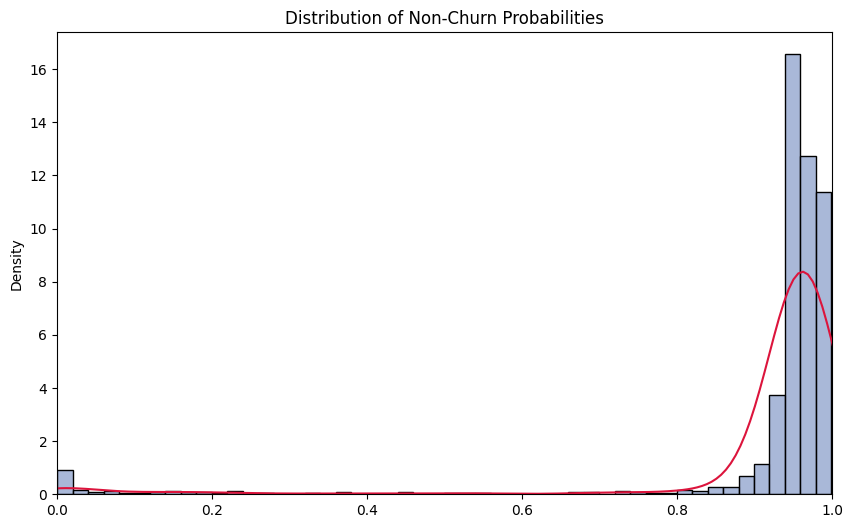

In [74]:
# plot distribution of probabilities
plt.figure(figsize=(10, 6))
sns.histplot(p_non_churn, stat="density", bins=50, color=sns.color_palette("Set2")[2])
sns.kdeplot(p_non_churn, color='crimson')
plt.title("Distribution of Non-Churn Probabilities")
plt.xlim(0, 1)
plt.show()

## 4.4. Linear Regression for CLV

Next, we are going to train a model to **predict CLV**.  
This model wil use the ``RFM variables`` as its features and will **only** be trained on examples with a **positive CLV**.  
We only use those positive instances as the bias caused by the zeros is exactly what we're trying to solve: we want to **predict CLV if customers do not churn!**

In [75]:
# initialize the model
clv_model = LinearRegression()

# train the model on the training examples with positive CLV
clv_model.fit(X=train_X_clv[train_y_churn == 0], y=train_y_clv[train_y_churn == 0])

LinearRegression()

In [76]:
# predict the CLV values for the test set
test_clv_preds = clv_model.predict(X=test_X_clv)

We will now **adjust** those predictions for donors we assume to be churners. As you saw during the churn case, this treshold very important. We now simply use the **standard 50% cut-off**, but you can try out multiple tresholds and select the best one. To do so, you will need a **validation set** as you saw during the acquisition case.

In [77]:
# threshold predictions to get predictions for clv greater than or equal to zero
predicted_retention = np.where(p_non_churn>0.5,1,0)

# multiply with predicted CLV values to correct for customers with CLV = 0
test_clv_preds_corrected = test_clv_preds * predicted_retention

In [78]:
# inspect original and corrected CLV values for first 10 test examples
for i in range(10):
    print("non-churn prob: %s -- original clv: %s -- corrected clv: %s" %(round(test_churn_preds[i, 0], 2), round(test_clv_preds[i], 2), round(test_clv_preds_corrected[i], 2)))

non-churn prob: 0.93 -- original clv: 720.58 -- corrected clv: 720.58
non-churn prob: 0.94 -- original clv: 815.14 -- corrected clv: 815.14
non-churn prob: 0.95 -- original clv: 767.63 -- corrected clv: 767.63
non-churn prob: 0.97 -- original clv: 635.29 -- corrected clv: 635.29
non-churn prob: 0.98 -- original clv: 716.55 -- corrected clv: 716.55
non-churn prob: 0.98 -- original clv: 821.66 -- corrected clv: 821.66
non-churn prob: 0.94 -- original clv: 697.25 -- corrected clv: 697.25
non-churn prob: 0.93 -- original clv: 792.49 -- corrected clv: 792.49
non-churn prob: 0.95 -- original clv: 691.97 -- corrected clv: 691.97
non-churn prob: 0.94 -- original clv: 781.47 -- corrected clv: 781.47


# 5. Evaluation

Evaluate by calculating ``MAE`` and ``RMSE`` and comparing against a **baseline model**.

In [79]:
# get the MAE and RMSE of model
rmse = mean_squared_error(y_true=test_y_clv, y_pred=test_clv_preds_corrected) ** 0.5
mae = mean_absolute_error(y_true=test_y_clv, y_pred=test_clv_preds_corrected)

print("the RMSE is: %s" %rmse)
print("the MAE is: %s" %mae)

the RMSE is: 377.56366738578583
the MAE is: 143.90472336620482


In [80]:
# get the MAE and RMSE of baseline model (here: the mean of training set)
rmse = mean_squared_error(y_true=test_y_clv, y_pred=[np.mean(train_y_clv) for i in range(len(test_y_clv))]) ** 0.5
mae = mean_absolute_error(y_true=test_y_clv, y_pred=[np.mean(train_y_clv) for i in range(len(test_y_clv))])

print("the RMSE of random model is: %s" %rmse)
print("the MAE of random model is: %s" %mae)

the RMSE of random model is: 437.1804330075091
the MAE of random model is: 197.47764227684328


In [81]:
# check mean CLV value of donors in training set
np.mean(train_y_clv) 

685.8117352149835

In [82]:
# get the MAE and RMSE of baseline model (here: the median of training set)
rmse = mean_squared_error(y_true=test_y_clv, y_pred=[np.median(train_y_clv) for i in range(len(test_y_clv))]) ** 0.5
mae = mean_absolute_error(y_true=test_y_clv, y_pred=[np.median(train_y_clv) for i in range(len(test_y_clv))])

print("the RMSE of random model is: %s" %rmse)
print("the MAE of random model is: %s" %mae)

the RMSE of random model is: 442.299560181064
the MAE of random model is: 155.439306512303


In [83]:
# check median CLV value of donors in training set
np.median(train_y_clv) 

770.9659366739965

Performance is only slightly better than using baseline model. This is probably because it would have even been better to use a **three-phase model** which models $P(defaultValue)$ seperately.

In [84]:
# compare to migration modeling technique
true = np.sum(test_y_clv)
est_clv = np.sum(test_clv_preds_corrected)

In [85]:
(est_clv-true)/true

0.021881032663575863

We are able to predict the **overall CLV** in the next 3 years with a **2.0% error rate**. This means that this approach approximately has **the same performance as migration modeling** on the aggregated level! 

Let's visualize how well our model performs by plotting the true CLV values next to our predicted CLV values. 

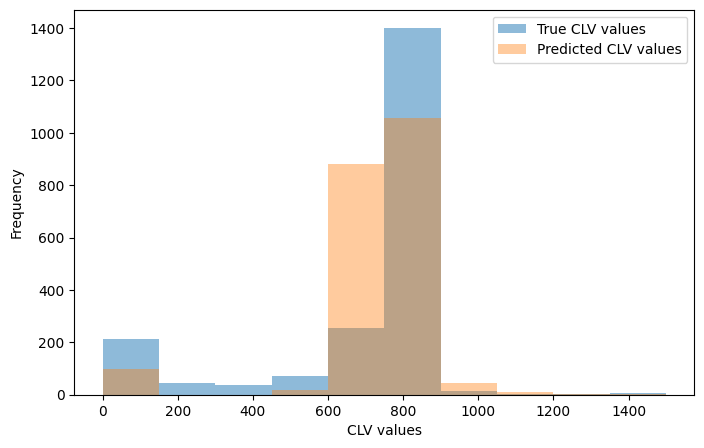

In [86]:
# plot predictions versus real values
plt.figure(figsize=(8, 5))
plt.hist(x=test_y_clv, bins=10, range=[0, 1500], alpha=0.5,  label="True CLV values")
plt.hist(x=test_clv_preds_corrected, bins=10, range=[0, 1500], alpha=0.4, label="Predicted CLV values")
plt.legend(loc="upper right")
plt.xlabel("CLV values")
plt.ylabel("Frequency")
plt.show()

**A little extra**: you can **order** the customers that have the highest predicted loss $(p(Churn) * E(CLV))$. Doing so, you know what customers will be **the most costly to lose**. These are the customers you need to focus on.

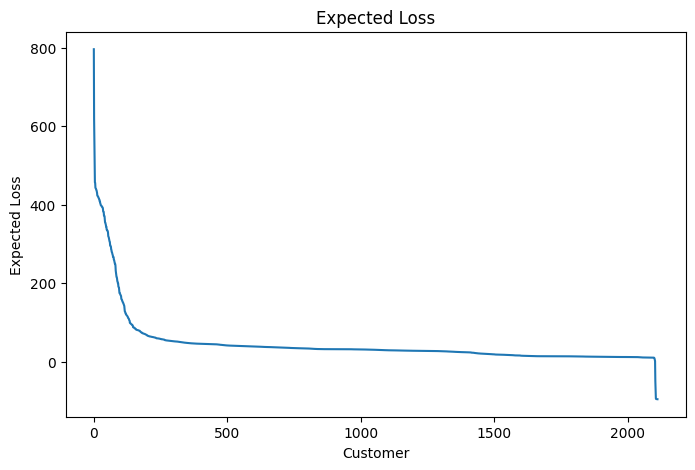

In [87]:
# plot sorted expected loss
test_expected_loss = test_clv_preds * test_churn_preds[:, 1]

plt.figure(figsize=(8, 5))
plt.plot(range(len(test_expected_loss)), sorted(test_expected_loss, reverse=True))
plt.title("Expected Loss")
plt.xlabel("Customer")
plt.ylabel("Expected Loss")
plt.show()